# Connectome manipulations & visualizations
This is the main script for connectome manipulations, which
 - applies a single or a sequence of manipulations to the connectome, as specified in the config
 - runs a structural and topological comparison of the raw and manipulated connectomes, producing visualizations as specified

In [1]:
# Initialization

""" Global imports """
import sys
import os.path
import numpy as np

""" Paths """
sys.path.insert(0, '../pipeline/')
sys.path.insert(0, '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/')

""" Local imports """
from connectome_manipulation import connectome_manipulation
from connectome_comparison import structural_comparator
from model_building import model_building
from topological_sampling.pipeline.gen_topo_db import gen_topo_db
from topological_comparator.pipeline import prepare_pipeline
from topological_comparator.pipeline.additional_stats import add_additional_stats
from topological_comparator.pipeline.contract_db import contract_db
from topological_comparator.pipeline.extract_connectivity import extract_connectivity_sonata
from topological_comparator.bin import compare_topo_db

In [2]:
# Connectome manipulation - Configuration
manip_config = {}

""" Circuit (base path) """
# manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build'
manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
# manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/sscx-white-matter'
circuit_name = os.path.split(manip_config['circuit_path'])[1]

""" General settings """
manip_config['seed'] = 3210
manip_config['N_split_nodes'] = 1

""" Manipulation (name + sequence of manipulation functions with arguments) """
# manip_config['manip'] = {'name': 'NoManip', 'fcts': [{'source': 'no_manipulation', 'kwargs': {}}]} # Just for testing

# manip_config['manip'] = {'name': 'RemoveAllSynToL5', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer5', 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnToL5', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer5', 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'Remove50pctAllSyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllConn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}

# manip_config['manip'] = {'name': 'RemoveAllConnWith1To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 1, 'max_syn_per_conn': 10}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnWith5To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 5, 'max_syn_per_conn': 10}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnWithOver20Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 21}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnExcept5To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'max_syn_per_conn': 4}},
#                                                                          {'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 11}}]}

# manip_config['manip'] = {'name': 'Remove50pctAllSyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_gsyn': True}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepConn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_conns': True}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepConnKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_conns': True, 'keep_gsyn': True}}]}
# manip_config['manip'] = {'name': 'RemoveAllSynKeepConn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True}}]}
# manip_config['manip'] = {'name': 'RemoveAllSynKeepConnKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}}]}
manip_config['manip'] = {'name': 'ReduceToPointNeuronModel', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

#manip_config['manip'] = {'name': 'SubsampleSyn10pct', 'fcts': [{'source': 'syn_subsampling', 'kwargs': {'keep_pct': 10.0}}]}

# manip_config['manip'] = {'name': 'RewireAxonsL4PC-L5PC', 'fcts': [{'source': 'axon_rewiring', 'kwargs': {'sel_grp1': {'mtype': ['L4_TPC', 'L4_UPC']}, 'sel_grp2': {'mtype': ['L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_UPC']}, 'R': 100.0, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ShuffleAxonsL4TPC', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': {'mtype': 'L4_TPC'}, 'R': 100.0, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ShuffleAxonsL456EXC', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': {'layer': [4, 5, 6], 'synapse_class': 'EXC'}, 'R': 100.0, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ScaleNrrpX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'n_rrp_vesicles', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsynX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsynX0.5', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.5}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleDelayX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'delay', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleDelayX0.5', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'delay', 'new_value': {'mode': 'scale', 'factor': 0.5}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ScaleGsyn0p1L4aff', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer4', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1L4eff', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'Layer4', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1ExcV1', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_filter': {'syn_type_id': list(range(100, 200))}, 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1ExcV2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': {'synapse_class': 'EXC'}, 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn2p0L4Exc-L4Exc', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': {'layer': 4, 'synapse_class': 'EXC'}, 'sel_dest': {'layer': 4, 'synapse_class': 'EXC'}, 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 2.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynSect', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynSegm', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSect', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSegm', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSectId', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ResetPostSynSectPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ResetPostSynSectType', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'InvalPreSynAll', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_x', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_y', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_z', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_x', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_y', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_z', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_id', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_pos', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_type', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_id', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_offset', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ShuffleExc', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': 'Excitatory', 'R': np.inf, 'amount_pct': 100.0}}]}

# Connectome manipulation - Apply manipulation
connectome_manipulation.main(manip_config, do_profiling=True)


PROFILING: 
************************************
* RESOURCE PROFILING [initial]     *
************************************
* Max. memory usage (GB):    0.121 *
************************************

INFO: Loading circuit from /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json (N_split=1)
INFO: Split 1/1: Loaded 568717 synapses with 35 properties between 5924 neurons
PROFILING: 
************************************
* RESOURCE PROFILING [loaded-1/1]  *
************************************
* Max. memory usage (GB):    0.216 *
* Max. memory diff. (GB):    0.096 *
************************************
* Total time (s):            0.858 *
* Elapsed time (s):          0.858 *
************************************

INFO: APPLYING MANIPULATION "ReduceToPointNeuronModel"
INFO: >>Step 1 of 6: source=syn_removal, kwargs={'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}
INFO: Removing 445081 (100.0%) of 4450

/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


PROFILING: 
************************************
* RESOURCE PROFILING [saved-1/1]   *
************************************
* Max. memory usage (GB):    1.360 *
* Max. memory diff. (GB):    0.000 *
************************************
* Total time (s):           66.349 *
* Elapsed time (s):          0.318 *
************************************

INFO: Total input/output synapse counts: 568717/123636

INFO: Converting 1 .parquet file(s) to SONATA
INFO: Writing to /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/networks/edges/functional/All/edges_ReduceToPointNeuronModel.h5
Aggregate totals: 123636 records (1 blocks)

Data conversion complete. 
Creating indices...
- Indexing A DATASET UPGRADE HIGHFIVE! using 1 ranks...
- Writing indexes out to hdf5...
- Indexing A DATASET UPGRADE HIGHFIVE! using 1 ranks...
- Writing indexes out to hdf5...
Finished writing /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/networks/edges/functional/Al

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config_ReduceToPointNeuronModel.json
INFO: Preparing "conn_per_layer" plot(s)...
INFO: Computing connectivity (group_by=layer, nrn_filter=None, N=6)


/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/bluepysnap/nodes.py:438: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pd.api.types.is_categorical(res) and not is_present:


INFO: Writing resutls to ../working_dir/structural_comparator/circuit-build-S1_v1/data/Raw_conn_per_layer.pickle
INFO: Computing connectivity (group_by=layer, nrn_filter=None, N=6)



100% |########################################################################|


INFO: Writing resutls to ../working_dir/structural_comparator/circuit-build-S1_v1/data/ReduceToPointNeuronModel_conn_per_layer.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-conn_per_layer-nsyn_conn.pdf...


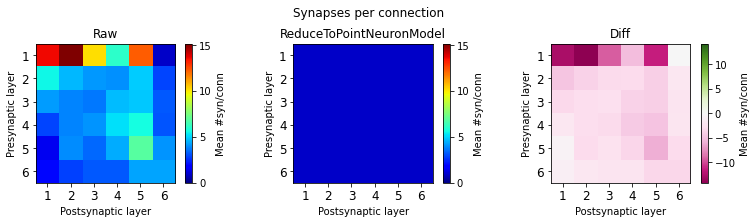

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-conn_per_layer-conn_prob.pdf...


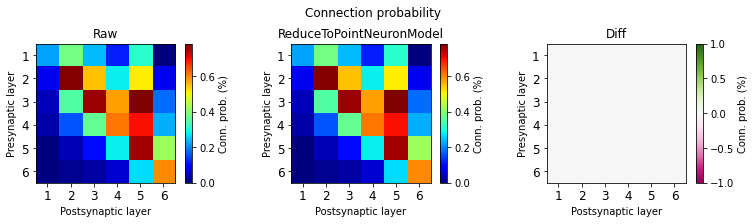

INFO: Preparing "syn_props_per_layer" plot(s)...
INFO: Extracting synapse properties (group_by=layer, nrn_filter=None, N=6)
INFO: Available synapse properties: 
['@source_node', '@target_node', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_pos', 'afferent_section_type', 'afferent_segment_id', 'afferent_segment_offset', 'afferent_surface_x', 'afferent_surface_y', 'afferent_surface_z', 'conductance', 'conductance_scale_factor', 'decay_time', 'delay', 'depression_time', 'efferent_center_x', 'efferent_center_y', 'efferent_center_z', 'efferent_section_id', 'efferent_section_pos', 'efferent_section_type', 'efferent_segment_id', 'efferent_segment_offset', 'efferent_surface_x', 'efferent_surface_y', 'efferent_surface_z', 'facilitation_time', 'n_rrp_vesicles', 'spine_length', 'syn_type_id', 'u_hill_coefficient', 'u_syn']


/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/bluepysnap/nodes.py:438: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pd.api.types.is_categorical(res) and not is_present:


INFO: Writing resutls to ../working_dir/structural_comparator/circuit-build-S1_v1/data/Raw_syn_props_per_layer.pickle
INFO: Extracting synapse properties (group_by=layer, nrn_filter=None, N=6)
INFO: Available synapse properties: 
['@source_node', '@target_node', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_pos', 'afferent_section_type', 'afferent_segment_id', 'afferent_segment_offset', 'afferent_surface_x', 'afferent_surface_y', 'afferent_surface_z', 'conductance', 'conductance_scale_factor', 'decay_time', 'delay', 'depression_time', 'efferent_center_x', 'efferent_center_y', 'efferent_center_z', 'efferent_section_id', 'efferent_section_pos', 'efferent_section_type', 'efferent_segment_id', 'efferent_segment_offset', 'efferent_surface_x', 'efferent_surface_y', 'efferent_surface_z', 'facilitation_time', 'n_rrp_vesicles', 'spine_length', 'syn_type_id', 'u_hill_coefficient', 'u_syn']



100% |########################################################################|


INFO: Writing resutls to ../working_dir/structural_comparator/circuit-build-S1_v1/data/ReduceToPointNeuronModel_syn_props_per_layer.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-conductance.pdf...


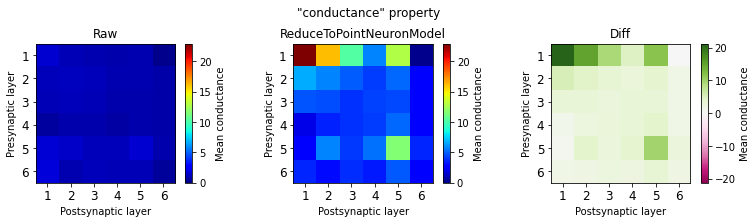

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-afferent_section_id.pdf...


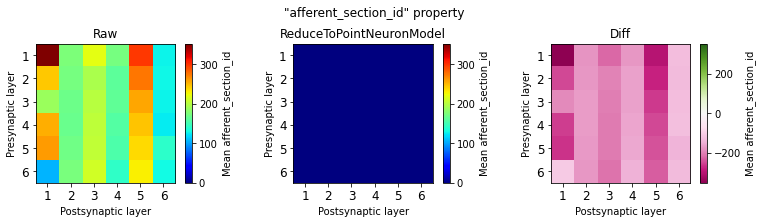

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-afferent_section_pos.pdf...


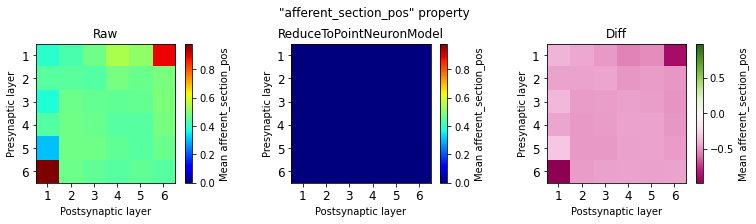

In [19]:
# Structural comparison of connectomes - Configuration
structcomp_config = {}

""" General settings """
structcomp_config['working_dir'] = os.path.join('..', 'working_dir', 'structural_comparator', circuit_name)
structcomp_config['out_dir'] = os.path.join('figures', circuit_name)

""" Types of structural plots """
# structcomp_config['plot_types'] = [{'name': 'inh_adjacency',
#                                     'fct': {'source': 'adjacency', 'kwargs': {'nrn_filter': {'synapse_class': 'INH'}}},
#                                     'res_sel': ['adj', 'adj_cnt'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3),
#                                     'fig_file': {'format': 'png', 'dpi': 600}}]

# structcomp_config['plot_types'] = [{'name': 'exc_conn_per_layer',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer', 'nrn_filter': {'synapse_class': 'EXC'}}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'exc_inh_conn',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'synapse_class'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'overall_conn',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': None}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'exc_syn_props_per_layer',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer', 'nrn_filter': {'synapse_class': 'EXC'}}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'syn_props_per_layer',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer'}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'syn_props_per_mtype',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'mtype'}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'conn_per_layer',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'conn_per_mtype',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'mtype'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'adjacency',
#                                     'fct': {'source': 'adjacency', 'kwargs': {}},
#                                     'res_sel': ['adj', 'adj_cnt'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3),
#                                     'fig_file': {'format': 'png', 'dpi': 600}}]

structcomp_config['plot_types'] = [{'name': 'conn_per_layer',
                                    'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer'}},
                                    'res_sel': ['nsyn_conn', 'conn_prob'],
                                    'range_prctile': 100,
                                    'fig_size': (11, 3)},
                                   {'name': 'syn_props_per_layer',
                                    'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer', 'fct': 'np.mean'}},
                                    'res_sel': ['conductance', 'afferent_section_id', 'afferent_section_pos'],
                                    'range_prctile': 100,
                                    'fig_size': (11, 3)}]

""" Circuits to compare """
structcomp_config['circuits'] = {'0': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json'),
                                       'circuit_name': 'Raw'},
                                 '1': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', f'circuit_config_{manip_config["manip"]["name"]}.json'),
                                       'circuit_name': manip_config['manip']['name']}}

# Structural comparison of connectomes - Run comparison
structural_comparator.main(structcomp_config, True, force_recomp=False)

In [4]:
# Topological comparison of connectomes - Configuration
topocomp_config = {}

""" General settings """
topocomp_config['working_dir'] = os.path.join('..', 'working_dir', 'topological_comparator', circuit_name)
topocomp_config['out_dir'] = os.path.join('figures', circuit_name)

""" Circuits to compare """
topocomp_config['circuits'] = {'0': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json'),
                                     'circuit_name': 'Raw'},
                               '1': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', f'circuit_config_{manip_config["manip"]["name"]}.json'),
                                     'circuit_name': manip_config["manip"]["name"]}}

# Topological comparison of connectomes - Prepare topological database
topocomp_force_recomp = False
topocomp_config_files = {}
for cidx in sorted(topocomp_config['circuits'].keys()):
    wrkdir = os.path.join(topocomp_config['working_dir'], topocomp_config['circuits'][cidx]['circuit_name'])
    topocomp_config_files[cidx] = os.path.join(wrkdir, 'config', 'common_config.json')
    if os.path.exists(wrkdir) and not topocomp_force_recomp:
        print(f'INFO: Folder {wrkdir} already exists ... SKIPPING', flush=True)
    else:
        print(f'INFO: Preparing pipeline in {wrkdir}', flush=True)
        prepare_pipeline.prepare_and_place_files(topocomp_config['circuits'][cidx]['circuit_config'], 'All', wrkdir)
        extract_connectivity_sonata.main(topocomp_config_files[cidx])
        gen_topo_db.main(topocomp_config_files[cidx])


INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/Raw already exists ... SKIPPING
INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/RewireAxonsL4PC-L5PC already exists ... SKIPPING


Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params.pdf...


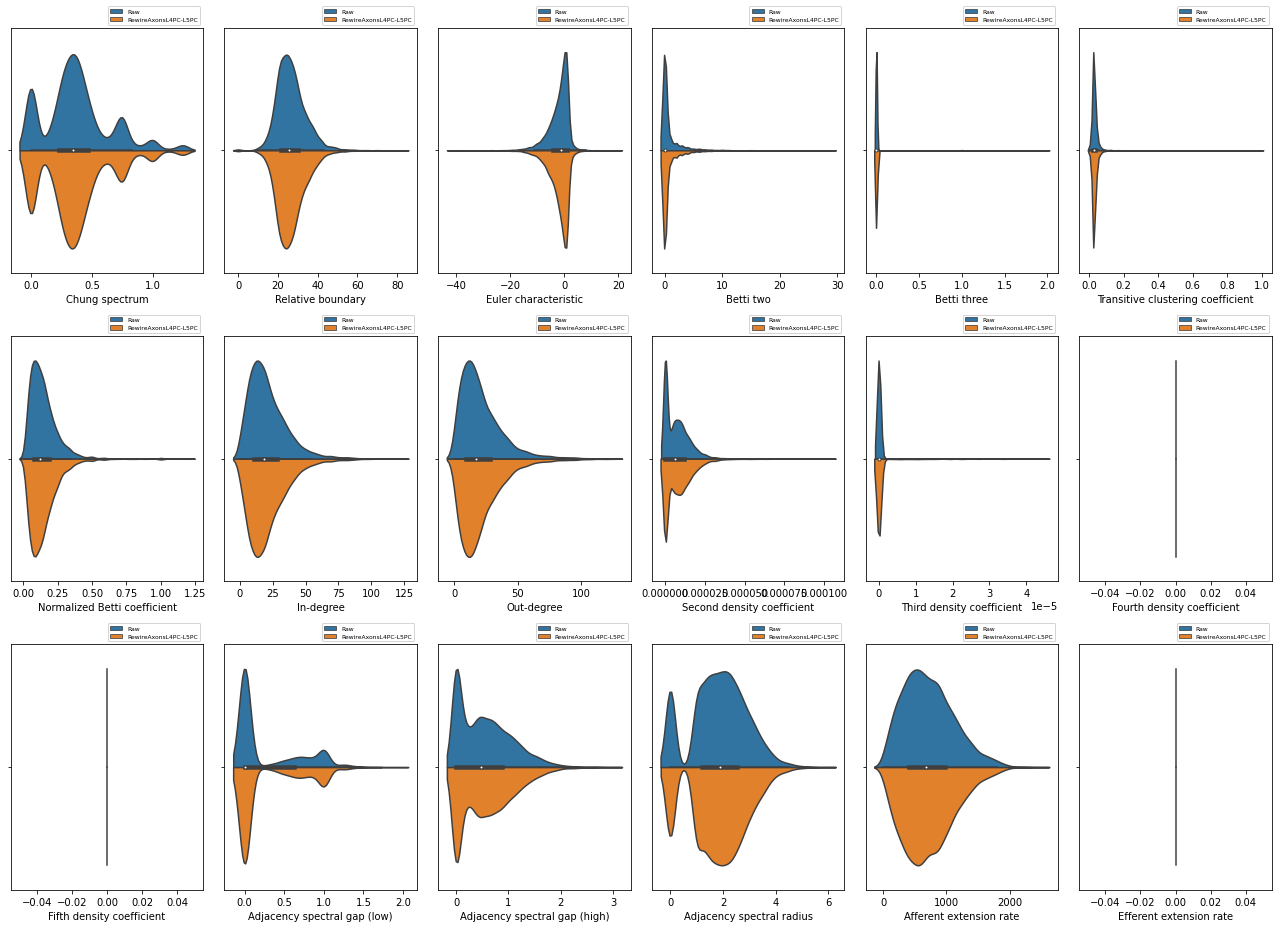

Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params-per_mtype.pdf...


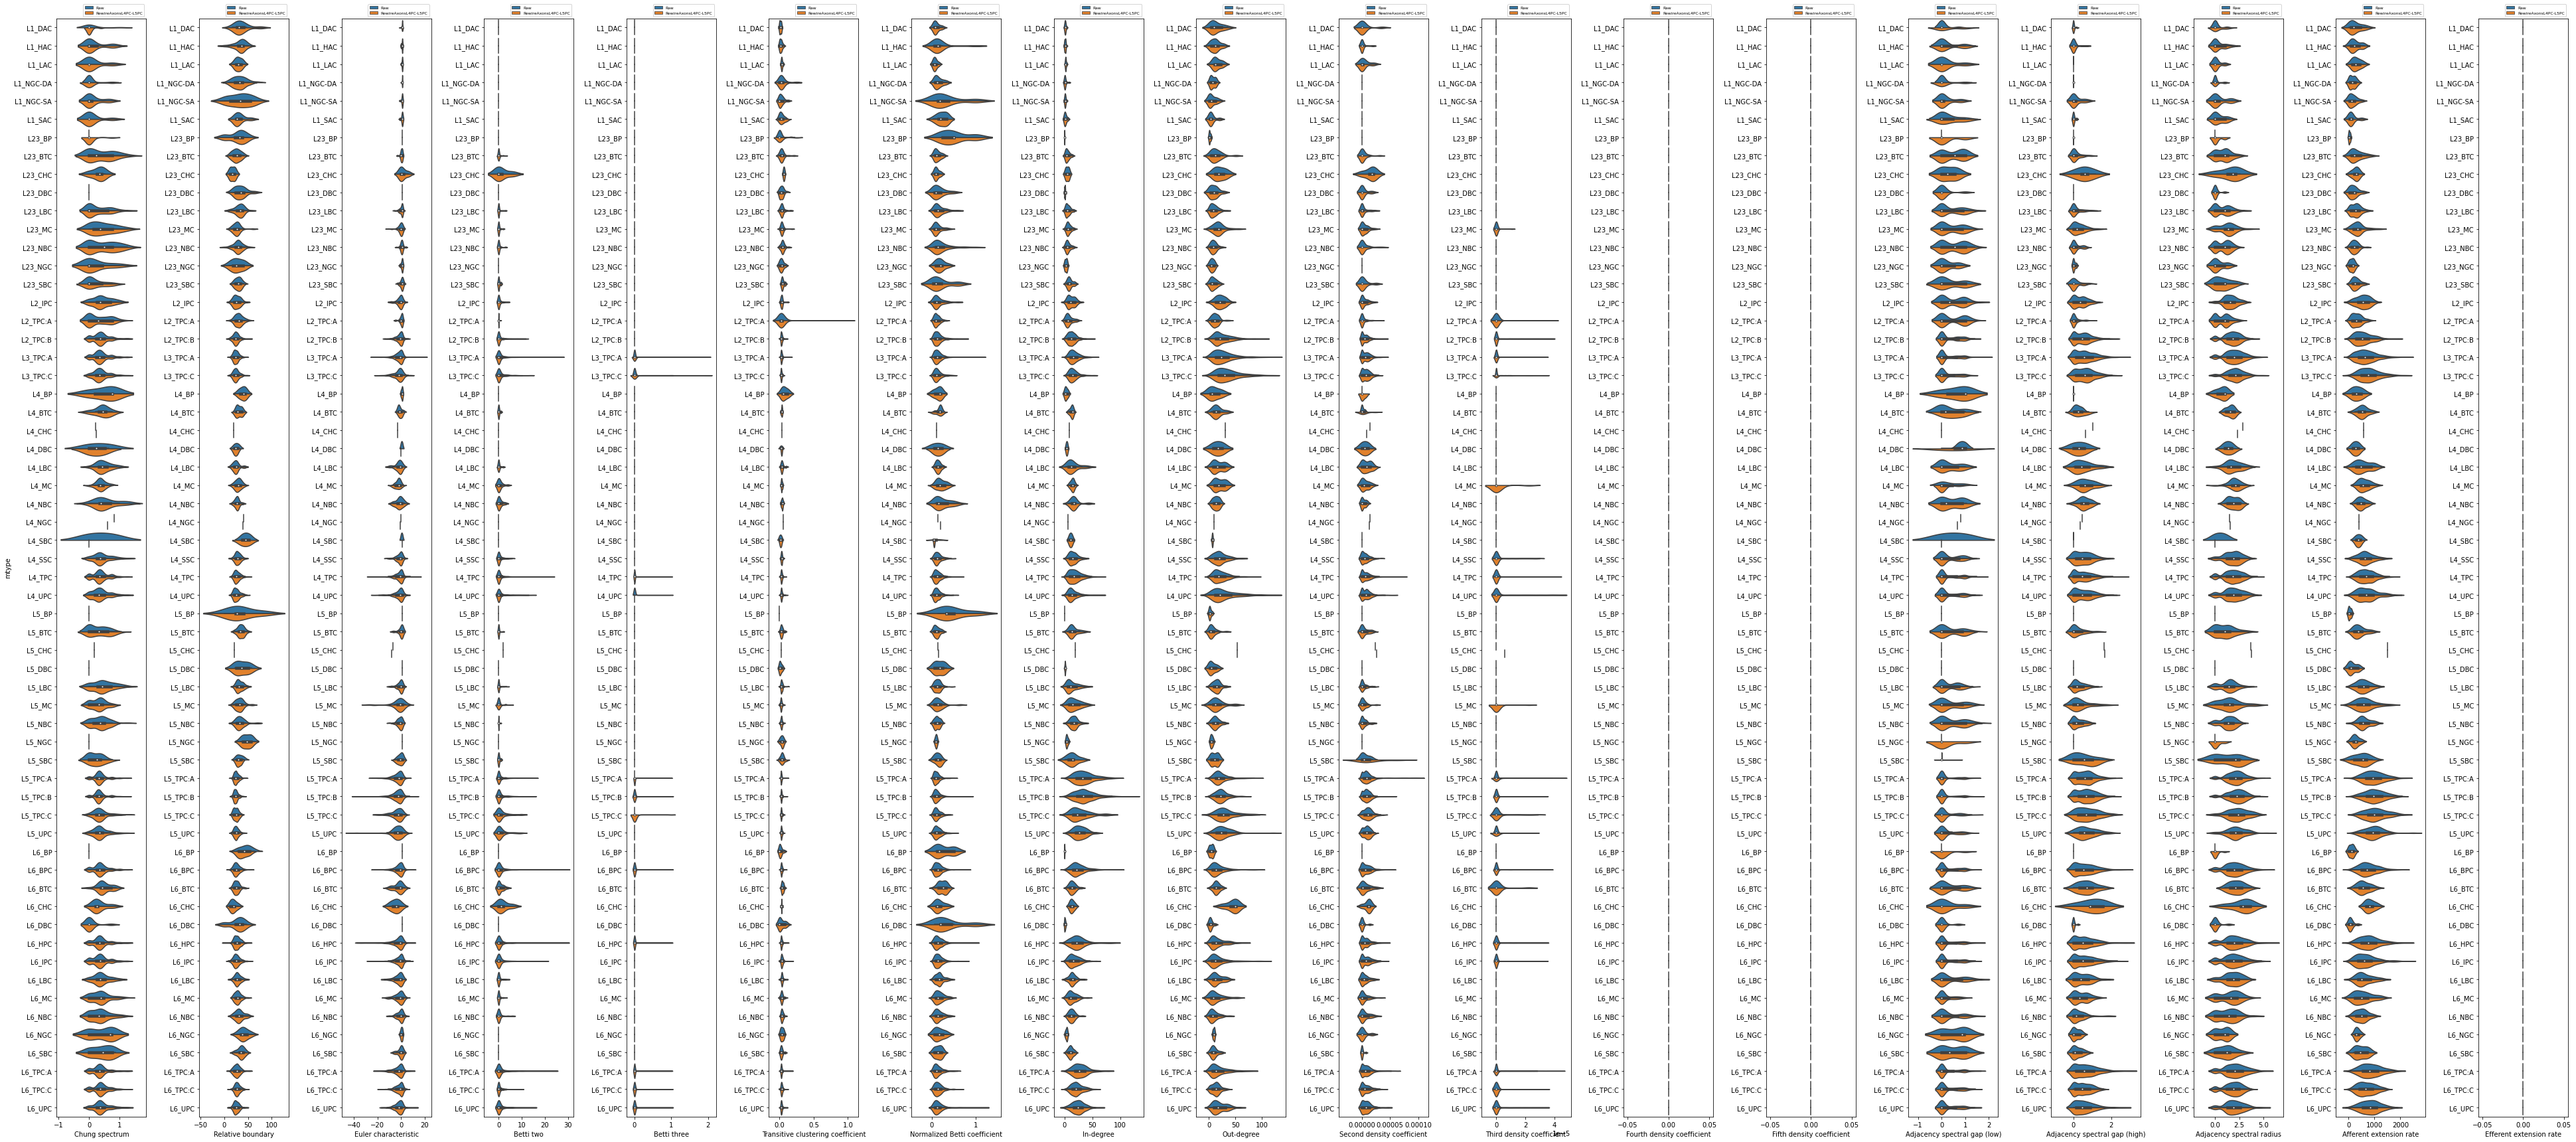

Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params-per_layer.pdf...


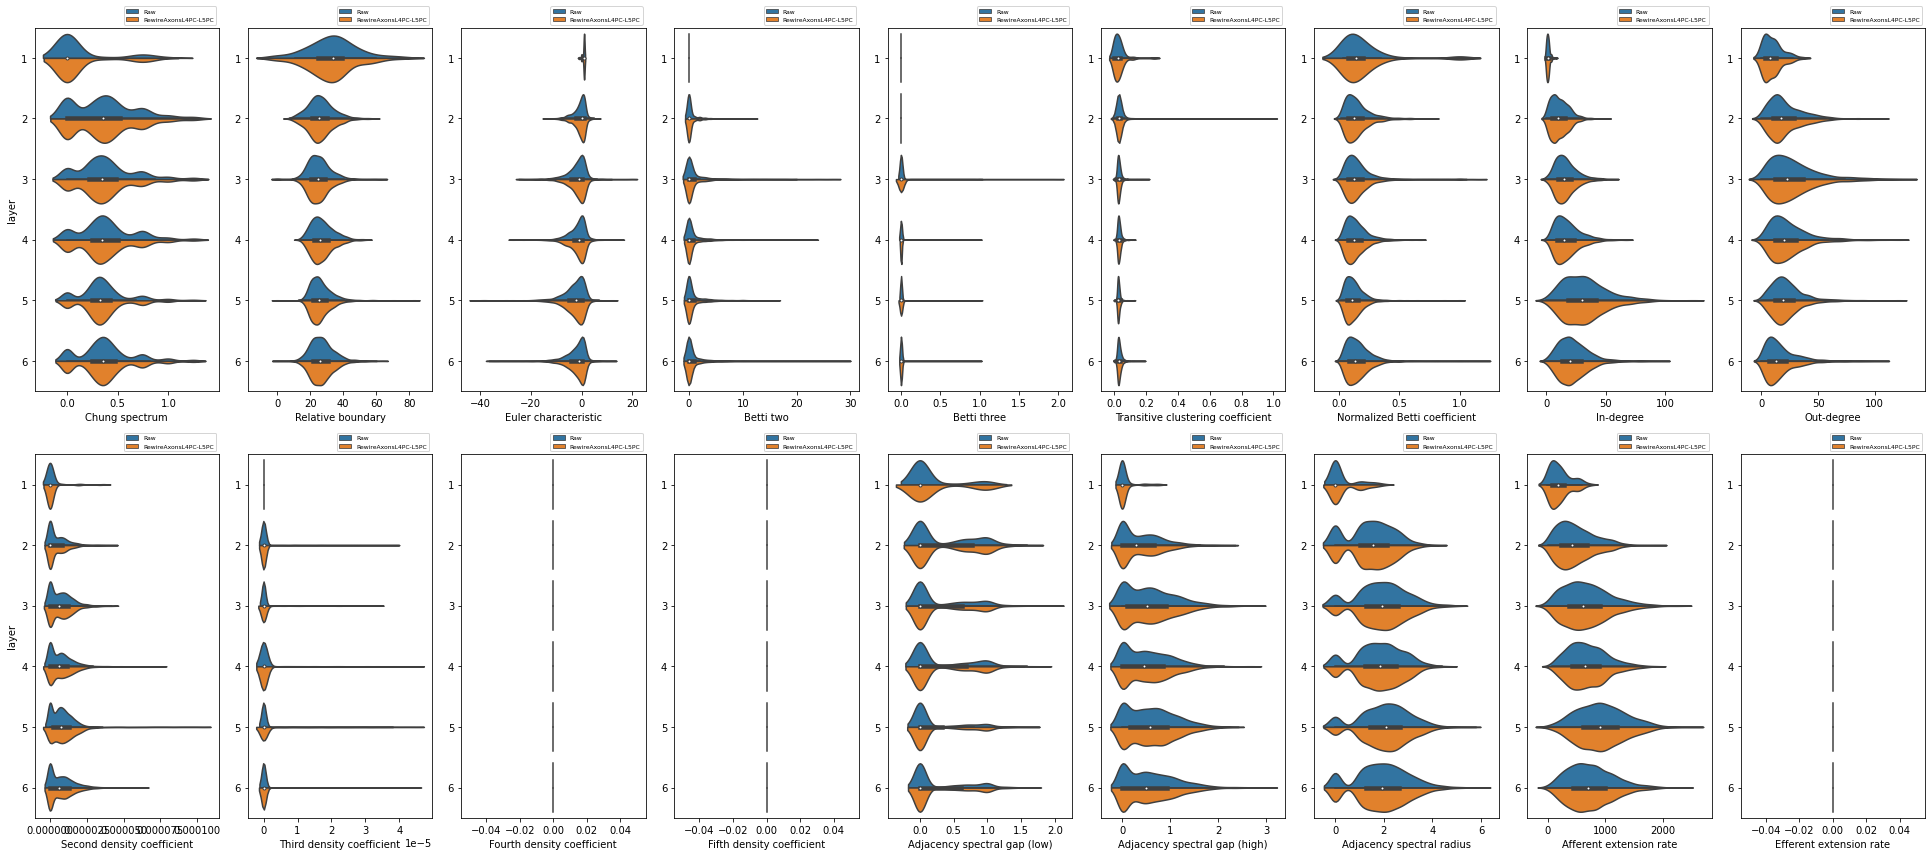

In [5]:
# Topological comparison of connectomes - Plot comparison
topocomp_db_dict, topocomp_param_dict = compare_topo_db.read_topo_dbs_and_parameter_specs({topocomp_config['circuits'][cidx]['circuit_name']: topocomp_config_files[cidx] for cidx in sorted(topocomp_config_files.keys())})
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, '', topocomp_config['out_dir'], num_rows=3, show_fig=True)
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'mtype', topocomp_config['out_dir'], num_rows=1, show_fig=True)
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'layer', topocomp_config['out_dir'], num_rows=2, show_fig=True)


In [ ]:
assert False, 'STOP HERE'

In [5]:
### ACCESS EDGE TABLE (DEVELOPMENT)
from bluepysnap.circuit import Circuit
from bluepysnap.sonata_constants import Node
from bluepysnap.sonata_constants import Edge

circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
circuit_name = os.path.split(circuit_path)[-1]
sonata_config =  os.path.join(circuit_path, 'sonata', 'circuit_config.json') # [Using default name]
# sonata_config =  os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json') # [Using default name]
c = Circuit(sonata_config)
nodes = c.nodes['All']
node_ids = nodes.ids()
edges = c.edges['default']
edges_table = edges.afferent_edges(node_ids, properties=sorted(edges.property_names))
circuit = c

In [4]:
# Model building - Configuration
circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
circuit_name = os.path.split(circuit_path)[-1]

model_config = {}

""" General settings """
model_config['working_dir'] = os.path.join('..', 'working_dir', 'model_building', circuit_name)
model_config['out_dir'] = os.path.join('figures', circuit_name)
model_config['seed'] = 7531

""" Model specifications """
model_config['circuit_config'] = os.path.join(circuit_path, 'sonata', 'circuit_config.json')
# model_config['model'] = {'name': 'DistDepDelay', 'fct': {'source': 'delay', 'kwargs': {'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}
# model_config['model'] = {'name': 'ConnProb1stOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 1, 'sample_size': 1000}}}
# model_config['model'] = {'name': 'ConnProb2ndOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 2, 'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}
model_config['model'] = {'name': 'ConnProb3rdOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 3, 'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}

# Model building - Run
model_building.main(model_config, True, force_recomp=True)

INFO: Circuit loaded: /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json
INFO: Running order-3 data extraction...
Extracting 2-dimensional (22x2) connection probabilities...


100% |########################################################################|


INFO: Writing data to ../working_dir/model_building/circuit-build-S1_v1/data/ConnProb3rdOrder.pickle
INFO: Running order-3 model building...
[[7.54300838e-02 6.21967358e-02]
 [3.97615814e-02 2.34646145e-02]
 [1.54790127e-02 8.64593502e-03]
 [6.56521134e-03 4.01336241e-03]
 [4.33175249e-03 1.82979200e-03]
 [3.01445164e-03 1.01072790e-03]
 [2.34589564e-03 7.81965212e-04]
 [2.50637304e-03 5.56971787e-04]
 [1.70586715e-03 5.94468855e-04]
 [1.81856757e-03 3.33404055e-04]
 [1.57617626e-03 3.35356652e-04]
 [1.02618677e-03 3.80069173e-05]
 [6.26650553e-04 1.34282261e-04]
 [2.25619042e-04 5.64047606e-05]
 [5.84624379e-04 7.30780474e-05]
 [1.01061142e-04 0.00000000e+00]
 [4.69336671e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
INFO: Writing model to ../working_dir/model_building/circuit-build-S1_v1/model/ConnProb3rdOrder.pickle


TypeError: plot() argument after ** must be a mapping, not NoneType

Computing distance-dependent delay histograms...


MODEL FIT: f_mean(x) = 0.004 * x + 0.601 ms
           f_std(x)  = 0.540 ms


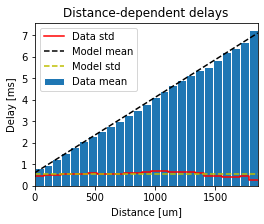

In [5]:
# Estimate distance-dependent delays
src_pos = nodes.positions(edges_table['@source_node'].to_numpy()).to_numpy() # Soma position of pre-synaptic neuron
tgt_pos = edges_table[['afferent_center_x', 'afferent_center_y', 'afferent_center_z']].to_numpy() # Synapse position on post-synaptic dendrite
src_tgt_dist = np.sqrt(np.sum((tgt_pos - src_pos)**2, 1))
src_tgt_delay = edges_table['delay'].to_numpy()

num_bins = 25
dist_bins = np.linspace(0, max(src_tgt_dist), num_bins + 1)
bin_offset = 0.5 * np.diff(dist_bins[:2])[0]
hist_delay_mean = np.zeros(num_bins)
hist_delay_std = np.zeros(num_bins)

print('Computing distance-dependent delay histograms...', flush=True)
import progressbar
pbar = progressbar.ProgressBar()
for idx in pbar(range(num_bins)):
    d_sel = np.logical_and(src_tgt_dist >= dist_bins[idx], (src_tgt_dist < dist_bins[idx + 1]) if idx < num_bins - 1 else (src_tgt_dist <= dist_bins[idx + 1])) # Including last edge
    hist_delay_mean[idx] = np.mean(src_tgt_delay[d_sel])
    hist_delay_std[idx] = np.std(src_tgt_delay[d_sel])

# Fit linear model for mean delay (const model for std)
from sklearn.linear_model import LinearRegression
lin_model_delay_mean = LinearRegression().fit(np.array(dist_bins[:-1] + bin_offset, ndmin=2).T, hist_delay_mean)
const_model_delay_std = lambda x: np.ones_like(x) * np.mean(hist_delay_std)

print(f'MODEL FIT: f_mean(x) = {lin_model_delay_mean.coef_[0]:.3f} * x + {lin_model_delay_mean.intercept_:.3f} ms')
print(f'           f_std(x)  = {const_model_delay_std(0):.3f} ms')

# Plot delay
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.bar(dist_bins[:-1], hist_delay_mean, width=np.diff(dist_bins[:2])[0], align='edge', edgecolor='w', label='Data mean')
plt.step(dist_bins, np.concatenate((hist_delay_std[:1], hist_delay_std)), 'r', label='Data std')
plt.plot(dist_bins, lin_model_delay_mean.predict(np.array(dist_bins, ndmin=2).T), '--k', label='Model mean')
plt.plot(dist_bins, const_model_delay_std(dist_bins), '--y', label='Model std')
plt.xlim((0, max(src_tgt_dist)))
plt.xlabel('Distance [um]')
plt.ylabel('Delay [ms]')
plt.title(f'Distance-dependent delays')
plt.legend()
plt.show()

Computing adjacency matrix between 2962 neurons...


100% |########################################################################|


Overall connection probability: p = 0.004
Computing distance-dependent connection histograms...


100% |########################################################################|


MODEL FIT: f(x) = 0.147 * exp(-0.008 * x)


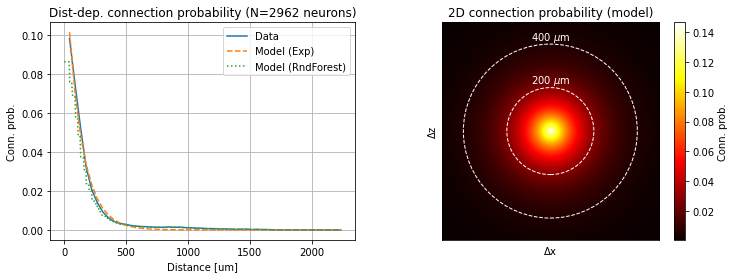

In [340]:
# Estimate & visualize distance-dependent connection probability
from scipy.spatial import distance_matrix
import progressbar
from scipy.optimize import curve_fit

num_sel = np.round(0.5 * len(node_ids)).astype(int) # Number of randomly selected neurons to estimate from
node_ids_sel = node_ids[np.random.permutation([True] * num_sel + [False] * (len(node_ids) - num_sel))]

# Compute distance matrix
nrn_pos = nodes.positions(node_ids_sel).to_numpy()
dist_mat = distance_matrix(nrn_pos, nrn_pos)
dist_mat[np.diag_indices(num_sel)] = np.nan # Exclude autaptic connections

# Compute adjacency matrix for given set of neurons
def compute_adjacency_matrix(circuit, node_ids=None):
        
    # Map node ids to continuous range of matrix indices
    all_node_ids = circuit.nodes['All'].ids()
    gid_min = min(all_node_ids)
    gid_max = max(all_node_ids)
    
    if node_ids is None:
        node_ids = all_node_ids

    mat_ids = np.full(gid_max - gid_min + 1, -1).astype(int)
    gid_offset = gid_min
    mat_ids[node_ids - gid_offset] = np.arange(len(node_ids))
    def gid_to_idx(gids):
        return mat_ids[gids - gid_offset]
    
    print(f'Computing adjacency matrix between {len(node_ids)} neurons...', flush=True)
    count_matrix = np.zeros([len(node_ids)] * 2).astype(int)
    pbar = progressbar.ProgressBar()
    for pre_idx in pbar(range(len(node_ids))):
        
        pre_gid = node_ids[pre_idx]
        conns = np.array(list(circuit.edges['default'].iter_connections(pre_gid, return_edge_count=True)))
        if len(conns) > 0:
            idx = gid_to_idx(conns[:, 1])
            count_matrix[gid_to_idx(pre_gid), idx[idx >= 0]] = conns[idx >= 0, 2] # Filter selected gids here [faster than selecting post GIDs within iter_connections]
    
    adj_matrix = count_matrix > 0
    
    return adj_matrix, count_matrix

adj_mat, _ = compute_adjacency_matrix(c, node_ids_sel)

# Compute overall connection probability (1st order model from [Gal et al. 2020])
assert not np.any(np.diag(adj_mat)), 'ERROR: Autaptic connection(s) found!'
p_conn = np.sum(adj_mat) / (adj_mat.size - num_sel) # Excluding autaptic connections
print(f'Overall connection probability: p = {p_conn:.3f}')

# Compute distance-dependent connection probability (2nd order model from [Gal et al. 2020])
num_bins = 50
hist_count_all = np.full(num_bins, -1) # Count of all pairs of neurons within given distance
hist_count_conn = np.full(num_bins, -1) # Count of connected pairs of neurons withing given distance
dist_bins = np.linspace(0, np.nanmax(dist_mat), num_bins + 1)
print('Computing distance-dependent connection histograms...', flush=True)
pbar = progressbar.ProgressBar()
for idx in pbar(range(num_bins)):
    d_sel = np.logical_and(dist_mat >= dist_bins[idx], (dist_mat < dist_bins[idx + 1]) if idx < num_bins - 1 else (dist_mat <= dist_bins[idx + 1])) # Including last edge
    hist_count_all[idx] = np.sum(d_sel)
    hist_count_conn[idx] = np.sum(adj_mat[d_sel])
p_conn_dist = hist_count_conn / hist_count_all

# Fit exp model
exp_model = lambda x, a, b: a * np.exp(-b * np.array(x))
(a_opt, b_opt), _ = curve_fit(exp_model, dist_bins[1:], p_conn_dist, p0=[0.0, 0.0])
opt_model = lambda x: exp_model(x, a_opt, b_opt)

print(f'MODEL FIT: f(x) = {a_opt:.3f} * exp(-{b_opt:.3f} * x)')

# Fit random forest model
from sklearn.ensemble import RandomForestRegressor

dist_regr_model = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0)
dist_regr_model.fit(np.array(dist_bins[:-1] + 0.5 * np.diff(dist_bins[:2])[0], ndmin=2).T, p_conn_dist)

# Plotting
plt.figure(figsize=(12, 4))

## Data vs. model fit
plt.subplot(1, 2, 1)
plt.plot(dist_bins[1:], p_conn_dist, label='Data')
plt.plot(dist_bins[1:], opt_model(dist_bins[1:]), '--', label='Model (Exp)')
model_pos = np.sort(np.random.uniform(low=dist_bins[0], high=dist_bins[-1], size=1000))
plt.plot(model_pos, dist_regr_model.predict(np.array(model_pos, ndmin=2).T), ':', label='Model (RndForest)')
plt.grid()
plt.xlabel('Distance [um]')
plt.ylabel('Conn. prob.')
plt.title(f'Dist-dep. connection probability (N={num_sel} neurons)')
plt.legend()

## 2D connection probability (model)
plt.subplot(1, 2, 2)
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(-plot_range, plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = opt_model(vdist)
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, -plot_range, plot_range), cmap=plt.cm.hot)
for r in r_markers:
    plt.gca().add_patch(plt.Circle((0, 0), r, edgecolor='w', linestyle='--', fill=False))
    plt.text(0, r, f'{r} $\mu$m', color='w', ha='center', va='bottom')
plt.xticks([])
plt.yticks([])
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$z')
plt.title('2D connection probability (model)')
plt.colorbar(label='Conn. prob.')

plt.show()


Computing bipolar distance-dependent connection histograms...


100% |########################################################################|


BIPOLAR MODEL FIT: f(x, sgn) = 0.150 * exp(-0.007 * x) if sgn < 0
                               0.148 * exp(-0.010 * x) if sgn > 0
                               AVERAGE OF BOTH MODELS  otherwise


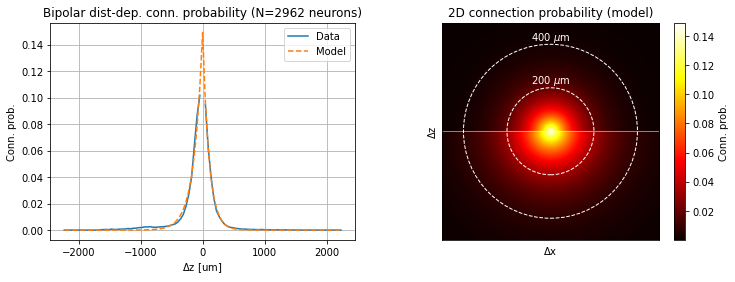

In [407]:
# Compute bipolar distance-dependent connection probability (3rd order model from [Gal et al. 2020])
bip_mat = np.sign(np.squeeze(np.diff(np.meshgrid(nrn_pos[:, 2], nrn_pos[:, 2], indexing='ij'), axis=0))) # Bipolar distinction based on difference in z coordinate
bip_values = [np.min(bip_mat), np.max(bip_mat)]
num_bins = 50
hist_count_all_bip = [np.full(num_bins, -1), np.full(num_bins, -1)] # Count of all pairs of neurons within given distance
hist_count_conn_bip = [np.full(num_bins, -1), np.full(num_bins, -1)] # Count of connected pairs of neurons withing given distance
dist_bins = np.linspace(0, np.nanmax(dist_mat), num_bins + 1)
print('Computing bipolar distance-dependent connection histograms...', flush=True)
pbar = progressbar.ProgressBar()
for idx in pbar(range(num_bins)):
    for bidx, bval in enumerate(bip_values):
        d_sel = np.logical_and(bip_mat == bval, np.logical_and(dist_mat >= dist_bins[idx], (dist_mat < dist_bins[idx + 1]) if idx < num_bins - 1 else (dist_mat <= dist_bins[idx + 1]))) # Including last edge
        hist_count_all_bip[bidx][idx] = np.sum(d_sel)
        hist_count_conn_bip[bidx][idx] = np.sum(adj_mat[d_sel])
p_conn_dist_bip = [hist_count_conn_bip[bidx] / hist_count_all_bip[bidx] for bidx in range(len(bip_values))]

# Fit bipolar exp model
(a1_opt, b1_opt), _ = curve_fit(exp_model, dist_bins[1:], p_conn_dist_bip[0], p0=[0.0, 0.0])
(a2_opt, b2_opt), _ = curve_fit(exp_model, dist_bins[1:], p_conn_dist_bip[1], p0=[0.0, 0.0])
opt_model_bip = lambda x, sgn: np.select([np.array(sgn) < 0, np.array(sgn) > 0, np.array(sgn) == 0], [exp_model(x, a1_opt, b1_opt), exp_model(x, a2_opt, b2_opt), 0.5 * (exp_model(x, a1_opt, b1_opt) + exp_model(x, a2_opt, b2_opt))])


print(f'BIPOLAR MODEL FIT: f(x, sgn) = {a1_opt:.3f} * exp(-{b1_opt:.3f} * x) if sgn < 0')
print(f'                               {a2_opt:.3f} * exp(-{b2_opt:.3f} * x) if sgn > 0')
print(f'                               AVERAGE OF BOTH MODELS  otherwise')

# Plotting
plt.figure(figsize=(12, 4))

## Data vs. model fit
plt.subplot(1, 2, 1)
bip_dist = np.concatenate((-dist_bins[1:][::-1], [0.0], dist_bins[1:]))
bip_data = np.concatenate((p_conn_dist_bip[0][::-1], [np.nan], p_conn_dist_bip[1]))
plt.plot(bip_dist, bip_data, label='Data')
plt.plot(bip_dist, opt_model_bip(np.abs(bip_dist), np.sign(bip_dist)), '--', label='Model')
plt.grid()
plt.xlabel('$\Delta$z [um]')
plt.ylabel('Conn. prob.')
plt.title(f'Bipolar dist-dep. conn. probability (N={num_sel} neurons)')
plt.legend()

## 2D connection probability (model)
plt.subplot(1, 2, 2)
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(-plot_range, plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = opt_model_bip(vdist, np.sign(zv))
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, plot_range, -plot_range), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
for r in r_markers:
    plt.gca().add_patch(plt.Circle((0, 0), r, edgecolor='w', linestyle='--', fill=False))
    plt.text(0, r, f'{r} $\mu$m', color='w', ha='center', va='bottom')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$z')
plt.title('2D connection probability (model)')
plt.colorbar(label='Conn. prob.')

plt.show()


In [408]:
# Compute offset-dependent connection probability (4th order model from [Gal et al. 2020])
dx_mat = np.squeeze(np.diff(np.meshgrid(nrn_pos[:, 0], nrn_pos[:, 0], indexing='ij'), axis=0)) # Relative difference in x coordinate
dy_mat = np.squeeze(np.diff(np.meshgrid(nrn_pos[:, 1], nrn_pos[:, 1], indexing='ij'), axis=0)) # Relative difference in y coordinate
dz_mat = np.squeeze(np.diff(np.meshgrid(nrn_pos[:, 2], nrn_pos[:, 2], indexing='ij'), axis=0)) # Relative difference in z coordinate

num_bins = [25, 25, 25] # Number of bins x/y/z direction
hist_count_all_offset = np.full(num_bins, -1) # Count of all pairs of neurons with given rel. distance in x/y/z direction
hist_count_conn_offset = np.full(num_bins, -1) # Count of connected pairs of neurons with given rel. distance in x/y/z direction
# dx_bins = np.linspace(np.nanmin(dx_mat), np.nanmax(dx_mat), num_bins[0] + 1)
# dy_bins = np.linspace(np.nanmin(dy_mat), np.nanmax(dy_mat), num_bins[1] + 1)
# dz_bins = np.linspace(np.nanmin(dz_mat), np.nanmax(dz_mat), num_bins[2] + 1)
dx_bins = np.linspace(-500, 500, num_bins[0] + 1)
dy_bins = np.linspace(-500, 500, num_bins[1] + 1)
dz_bins = np.linspace(-500, 500, num_bins[2] + 1)
x_bin_offset = 0.5 * np.diff(dx_bins[:2])[0]
y_bin_offset = 0.5 * np.diff(dy_bins[:2])[0]
z_bin_offset = 0.5 * np.diff(dz_bins[:2])[0]
dx_sel_mat = [np.logical_and(dx_mat >= dx_bins[ix], (dx_mat < dx_bins[ix + 1]) if ix < num_bins[0] - 1 else (dx_mat <= dx_bins[ix + 1])) for ix in range(num_bins[0])]
dy_sel_mat = [np.logical_and(dy_mat >= dy_bins[iy], (dy_mat < dy_bins[iy + 1]) if iy < num_bins[1] - 1 else (dy_mat <= dy_bins[iy + 1])) for iy in range(num_bins[1])]
dz_sel_mat = [np.logical_and(dz_mat >= dz_bins[iz], (dz_mat < dz_bins[iz + 1]) if iz < num_bins[2] - 1 else (dz_mat <= dz_bins[iz + 1])) for iz in range(num_bins[2])]
print('Computing offset-dependent connection histograms...', flush=True)
import time
t_start = time.time()
pbar = progressbar.ProgressBar()
for ix in pbar(range(num_bins[0])):
    for iy in range(num_bins[1]):
        for iz in range(num_bins[2]):
            dxyz_sel = np.logical_and(dx_sel_mat[ix], np.logical_and(dy_sel_mat[iy], dz_sel_mat[iz]))
            
            hist_count_all_offset[ix, iy, iz] = np.sum(dxyz_sel)
            hist_count_conn_offset[ix, iy, iz] = np.sum(adj_mat[dxyz_sel])
p_conn_offset = hist_count_conn_offset / hist_count_all_offset
p_conn_offset[np.isnan(p_conn_offset)] = 0.0

print(f'Elapsed time: {time.time() - t_start}s')

Computing offset-dependent connection histograms...


Elapsed time: 233.46848893165588s


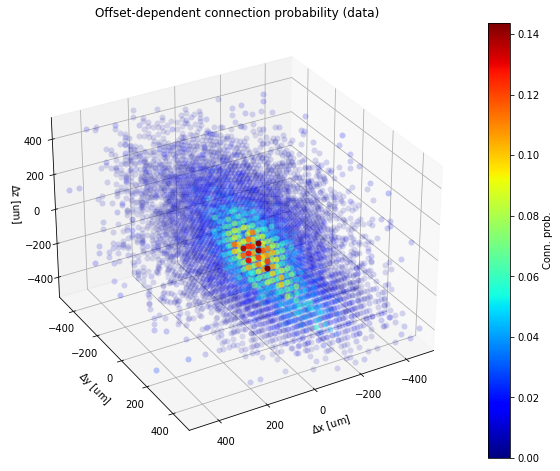

In [423]:
# Plotting

## 3D connection probability (data)
num_p_bins = 100
p_bins = np.linspace(0, np.max(p_conn_offset), num_p_bins + 1)
p_color_map = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=p_bins[0], vmax=p_bins[-1]))
p_colors = p_color_map.to_rgba(np.linspace(p_bins[0], p_bins[-1], num_p_bins))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for pidx in range(num_p_bins):
    p_sel_idx = np.where(np.logical_and(p_conn_offset > p_bins[pidx], p_conn_offset <= p_bins[pidx + 1]))
    plt.plot(dx_bins[p_sel_idx[0]] + x_bin_offset, dy_bins[p_sel_idx[1]] + y_bin_offset, dz_bins[p_sel_idx[2]] + z_bin_offset, 'o', color=p_colors[pidx, :], alpha=0.1 + 0.9 * (pidx + 1)/num_p_bins, markeredgecolor='none')
ax.view_init(30, 60)
ax.set_xlim((dx_bins[0], dx_bins[-1]))
ax.set_ylim((dy_bins[0], dy_bins[-1]))
ax.set_zlim((dz_bins[0], dz_bins[-1]))
ax.set_xlabel('$\Delta$x [um]')
ax.set_ylabel('$\Delta$y [um]')
ax.set_zlabel('$\Delta$z [um]')
plt.colorbar(p_color_map, label='Conn. prob.')
plt.title('Offset-dependent connection probability (data)')
plt.show()


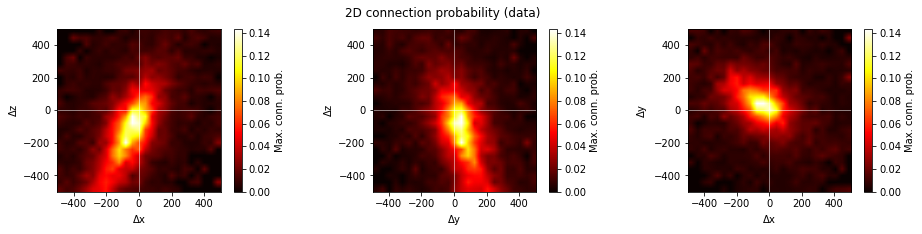

In [464]:
## Max. intensity projection (data)

plt.figure(figsize=(16, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.max(p_conn_offset, 1).T, interpolation='bilinear', extent=(dx_bins[0], dx_bins[-1], dz_bins[-1], dz_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$z')
plt.colorbar(label='Max. conn. prob.')

plt.subplot(1, 3, 2)
plt.imshow(np.max(p_conn_offset, 0).T, interpolation='bilinear', extent=(dy_bins[0], dy_bins[-1], dz_bins[-1], dz_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$y')
plt.ylabel('$\Delta$z')
plt.colorbar(label='Max. conn. prob.')

plt.subplot(1, 3, 3)
plt.imshow(np.max(p_conn_offset, 2).T, interpolation='bilinear', extent=(dx_bins[0], dx_bins[-1], dy_bins[-1], dy_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$y')
plt.colorbar(label='Max. conn. prob.')

plt.suptitle('2D connection probability (data)')
plt.show()

In [427]:
# Fit regression model (ensemble of decision trees => random forest)
from sklearn.ensemble import RandomForestRegressor

xv, yv, zv = np.meshgrid(dx_bins[:-1] + x_bin_offset, dy_bins[:-1] + y_bin_offset, dz_bins[:-1] + z_bin_offset, indexing='ij')
data_pos = np.array([xv.flatten(), yv.flatten(), zv.flatten()]).T
data_val = p_conn_offset.flatten()

offset_regr_model = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0)
offset_regr_model.fit(data_pos, data_val)


RandomForestRegressor(n_estimators=500, random_state=0)

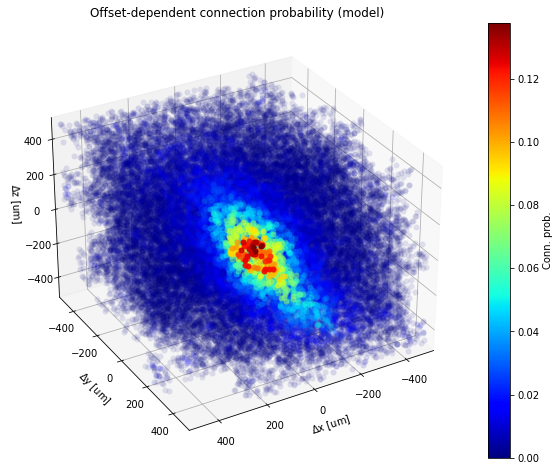

In [428]:
# Plotting

## 3D connection probability (model)
# model_pos = data_pos
# model_pos = data_pos + np.random.randn(*data_pos.shape) * 10
model_pos = np.random.uniform(low=[dx_bins[0], dy_bins[0], dz_bins[0]], high=[dx_bins[-1], dy_bins[-1], dz_bins[-1]], size=[50000, 3])
model_val = offset_regr_model.predict(model_pos)

num_p_bins = 100
p_bins = np.linspace(0, np.max(model_val), num_p_bins + 1)
p_color_map = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=p_bins[0], vmax=p_bins[-1]))
p_colors = p_color_map.to_rgba(np.linspace(p_bins[0], p_bins[-1], num_p_bins))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for pidx in range(num_p_bins):
    p_sel_idx = np.logical_and(model_val > p_bins[pidx], model_val <= p_bins[pidx + 1])
    plt.plot(model_pos[p_sel_idx, 0], model_pos[p_sel_idx, 1], model_pos[p_sel_idx, 2], 'o', color=p_colors[pidx, :], alpha=0.1 + 0.9 * (pidx + 1)/num_p_bins, markeredgecolor='none')
ax.view_init(30, 60)
ax.set_xlim((dx_bins[0], dx_bins[-1]))
ax.set_ylim((dy_bins[0], dy_bins[-1]))
ax.set_zlim((dz_bins[0], dz_bins[-1]))
ax.set_xlabel('$\Delta$x [um]')
ax.set_ylabel('$\Delta$y [um]')
ax.set_zlabel('$\Delta$z [um]')
plt.colorbar(p_color_map, label='Conn. prob.')
plt.title('Offset-dependent connection probability (model)')
plt.show()


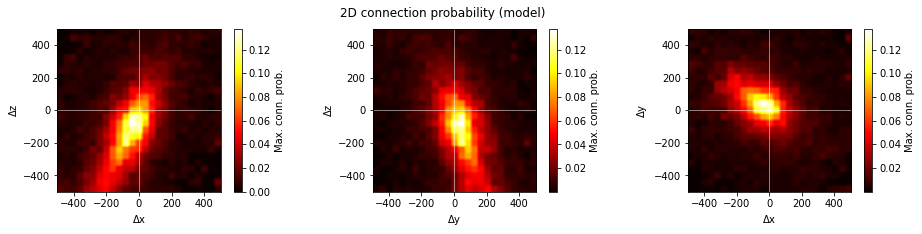

In [467]:
## Max. intensity projection (model)

num_bins = [50, 50, 50] # Number of bins x/y/z direction
dx_bins = np.linspace(-500, 500, num_bins[0] + 1)
dy_bins = np.linspace(-500, 500, num_bins[1] + 1)
dz_bins = np.linspace(-500, 500, num_bins[2] + 1)
x_bin_offset = 0.5 * np.diff(dx_bins[:2])[0]
y_bin_offset = 0.5 * np.diff(dy_bins[:2])[0]
z_bin_offset = 0.5 * np.diff(dz_bins[:2])[0]
xv, yv, zv = np.meshgrid(dx_bins[:-1] + x_bin_offset, dy_bins[:-1] + y_bin_offset, dz_bins[:-1] + z_bin_offset, indexing='ij')

model_pos = np.array([xv.flatten(), yv.flatten(), zv.flatten()]).T
model_val = offset_regr_model.predict(model_pos)
p_conn_model_offset = model_val.reshape(num_bins)

plt.figure(figsize=(16, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.max(p_conn_model_offset, 1).T, interpolation='bilinear', extent=(dx_bins[0], dx_bins[-1], dz_bins[-1], dz_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$z')
plt.colorbar(label='Max. conn. prob.')

plt.subplot(1, 3, 2)
plt.imshow(np.max(p_conn_model_offset, 0).T, interpolation='bilinear', extent=(dy_bins[0], dy_bins[-1], dz_bins[-1], dz_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$y')
plt.ylabel('$\Delta$z')
plt.colorbar(label='Max. conn. prob.')

plt.subplot(1, 3, 3)
plt.imshow(np.max(p_conn_model_offset, 2).T, interpolation='bilinear', extent=(dx_bins[0], dx_bins[-1], dy_bins[-1], dy_bins[0]), cmap=plt.cm.hot)
plt.plot(plt.xlim(), np.zeros(2), 'w', linewidth=0.5)
plt.plot(np.zeros(2), plt.ylim(), 'w', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$\Delta$x')
plt.ylabel('$\Delta$y')
plt.colorbar(label='Max. conn. prob.')

plt.suptitle('2D connection probability (model)')
plt.show()